### The impact of war and covid on the price of the consumer basket.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [5]:
file_path = "basket_prices_corr.csv"
df = pd.read_csv(file_path)

df.head()

,Місяць,Картопля,Ковбасні вироби,Крупи,Мʼясо свійських тварин та птиці,Макарони,"Молоко пастеризоване жирністю до 2,6% включно",Молочні продукти,Овочі,Олія соняшникова,Риба,Сир,Хліб,Цукор,Яблука,Яйця,basket_price
0,2019-M01,9.33,85.19,18.17,102.34,17.61,23.87,48.66,13.71,35.12,74.40,98.81,17.84,14.02,9.47,24.77,1311.51
1,2019-M02,10.09,85.52,18.61,100.94,17.82,24.13,48.99,14.50,35.07,75.58,99.67,18.05,14.13,9.43,23.90,1321.89
2,2019-M03,10.16,85.35,19.01,100.54,18.00,24.18,49.23,14.94,34.98,76.67,100.15,18.22,14.16,9.48,22.70,1325.04
3,2019-M04,10.73,85.55,19.86,102.16,18.19,24.32,49.68,19.13,34.95,77.26,100.86,18.39,14.08,9.49,20.20,1351.45
4,2019-M05,14.07,84.40,20.21,103.90,18.25,24.25,49.72,22.81,34.93,77.77,99.96,18.68,14.25,11.12,17.00,1394.55


In [6]:
file_path = "salaries.csv"
df_2 = pd.read_csv(file_path)

In [7]:
df_2

,Month,Salary
0,2019-M01,8186.94
1,2019-M02,8328.77
2,2019-M03,8814.84
3,2019-M04,8664.25
4,2019-M05,9081.68
...,...,...
67,2024-M08,17001.36
68,2024-M09,18020.86
69,2024-M10,18704.98
70,2024-M11,18823.31


In [8]:
df["salary"] = df_2["Salary"]

In [9]:
df["Місяць"] = df["Місяць"].str.replace(r"(\d{4})-M(\d{2})", r"\1-\2", regex=True)
df["Місяць"] = pd.to_datetime(df["Місяць"])

In [10]:
df["Місяць"]

0    2019-01-01
1    2019-02-01
2    2019-03-01
3    2019-04-01
4    2019-05-01
        ...    
67   2024-08-01
68   2024-09-01
69   2024-10-01
70   2024-11-01
71   2024-12-01
Name: Місяць, Length: 72, dtype: datetime64[ns]

CPI

In [11]:
base_price = df.loc[df["Місяць"] == "2019-01-01", "basket_price"].values[0]
df['CPI'] = (df['basket_price'] / base_price) * 100

In [12]:
df['CPI']

0     100.000000
1     100.791454
2     101.031635
3     103.045345
4     106.331633
         ...    
67    184.534620
68    187.816334
69    196.642039
70    207.119275
71    212.042607
Name: CPI, Length: 72, dtype: float64

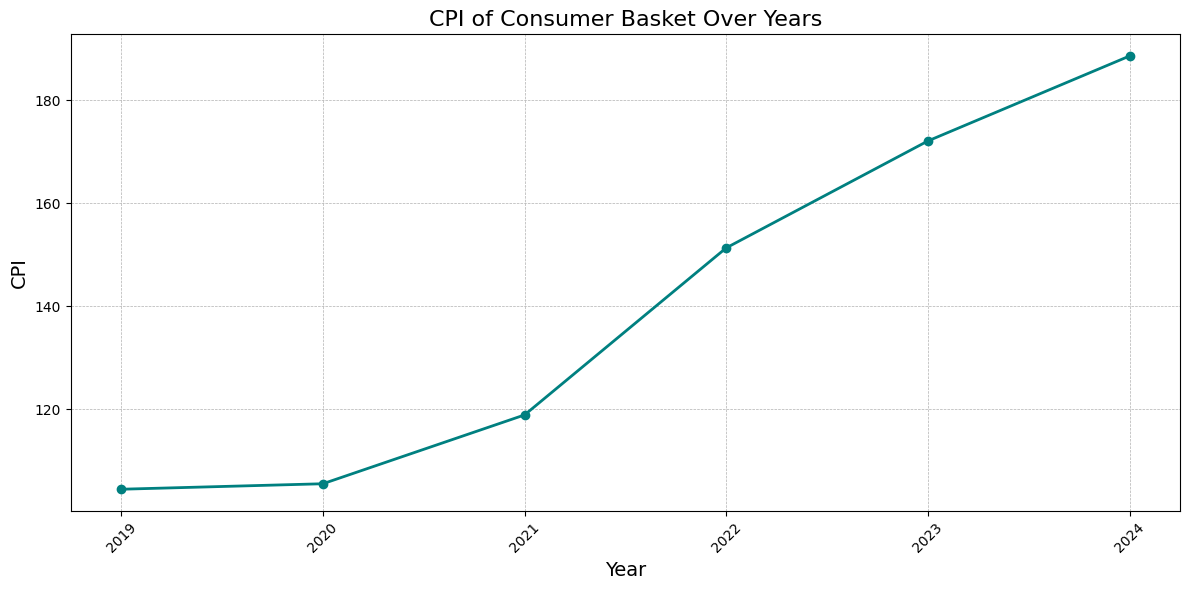

In [13]:
df['Year'] = pd.to_datetime(df['Місяць']).dt.year
yearly_cpi = df.groupby("Year")["CPI"].mean()

plt.figure(figsize=(12, 6))
plt.plot(yearly_cpi.index, yearly_cpi.values, marker="o", linewidth=2, color="teal")
plt.title("CPI of Consumer Basket Over Years", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("CPI", fontsize=14)
plt.xticks(yearly_cpi.index, rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

$$
\text{CPI\_price} = \beta_0 + \beta_1 \cdot \text{covid} + \beta_2 \cdot \text{war} + \beta_3 \cdot \text{time} + \sum \beta_{\text{month}_i} \cdot D_i + \epsilon
$$

In [14]:
df["covid"] = ((df["Місяць"] >= "2020-03-01") & (df["Місяць"] <= "2021-03-01")).astype(int)
df["war"] = ((df["Місяць"] >= "2022-03-01") & (df["Місяць"] <= "2023-03-01")).astype(int)
df["time"] = np.arange(len(df))
df["month"] = df["Місяць"].dt.month.astype("category")

X = pd.get_dummies(df[["covid", "war", "time", "month"]], drop_first=True).astype(float)
y = df["CPI"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     76.25
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.35e-31
Time:                        13:54:12   Log-Likelihood:                -247.28
No. Observations:                  72   AIC:                             524.6
Df Residuals:                      57   BIC:                             558.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.4765      3.886     23.023      0.0

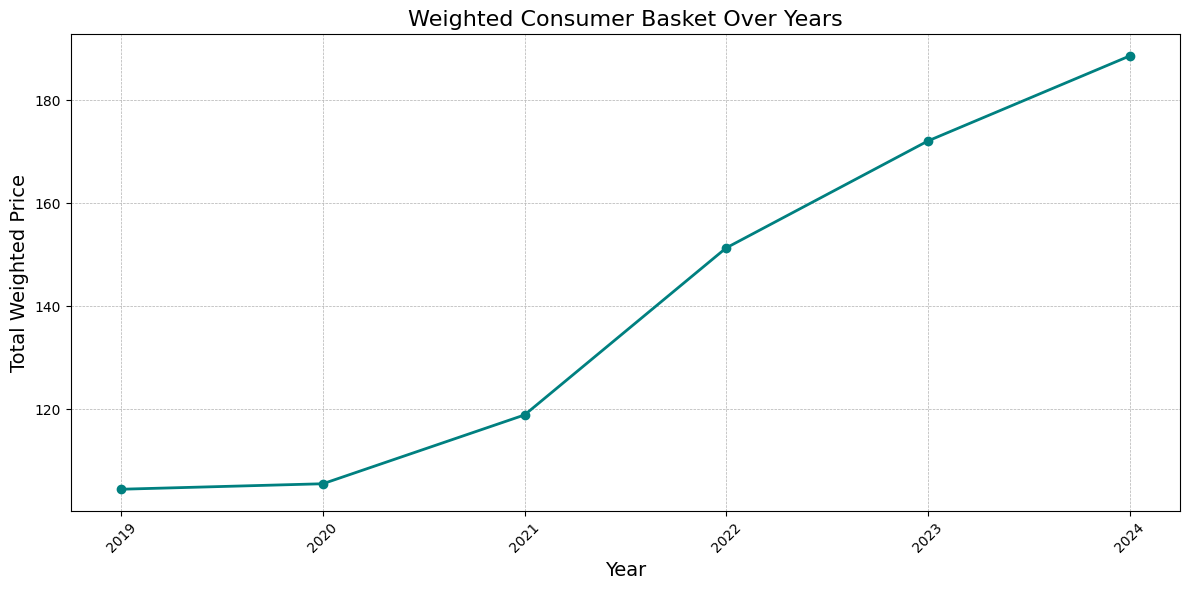

In [15]:
yearly_sum = df.groupby("Year")["basket_price"].sum()

plt.figure(figsize=(12, 6))
plt.plot(yearly_cpi.index, yearly_cpi.values, marker="o", linewidth=2, color="teal")
plt.title("Weighted Consumer Basket Over Years", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Weighted Price", fontsize=14)
plt.xticks(yearly_cpi.index, rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

$$
\text{basket\_price} = \beta_0 + \beta_1 \cdot \text{covid} + \beta_2 \cdot \text{war} + \beta_3 \cdot \text{time} + \sum \beta_{\text{month}_i} \cdot D_i + \epsilon
$$


time - trend(Steady monthly growth of ≈ UAH 375)

month(base - january) - Seasonal effects are not statistically significant

In [16]:
X = pd.get_dummies(df[["covid", "war", "time", "month"]], drop_first=True).astype(float)
y = df["basket_price"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           basket_price   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     76.25
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.35e-31
Time:                        13:54:12   Log-Likelihood:                -432.60
No. Observations:                  72   AIC:                             895.2
Df Residuals:                      57   BIC:                             929.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1173.4931     50.971     23.023      0.0

In [17]:
X = pd.get_dummies(df[["covid", "war", "salary", "time", "month"]], drop_first=True).astype(float)
y = df["basket_price"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           basket_price   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     74.02
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           2.68e-31
Time:                        13:54:12   Log-Likelihood:                -430.64
No. Observations:                  72   AIC:                             893.3
Df Residuals:                      56   BIC:                             929.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1432.3305    154.778      9.254      0.0

In [18]:
df[["time", "salary"]].corr()


,time,salary
time,1.000000,0.926366
salary,0.926366,1.000000


In [19]:
df["detrended"] = df["basket_price"].diff()

In [20]:
adf_result = adfuller(df["detrended"].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic: -5.717177335715139
p-value: 7.076745076122443e-07
Critical Value 1%: -3.5274258688046647
Critical Value 5%: -2.903810816326531
Critical Value 10%: -2.5893204081632653


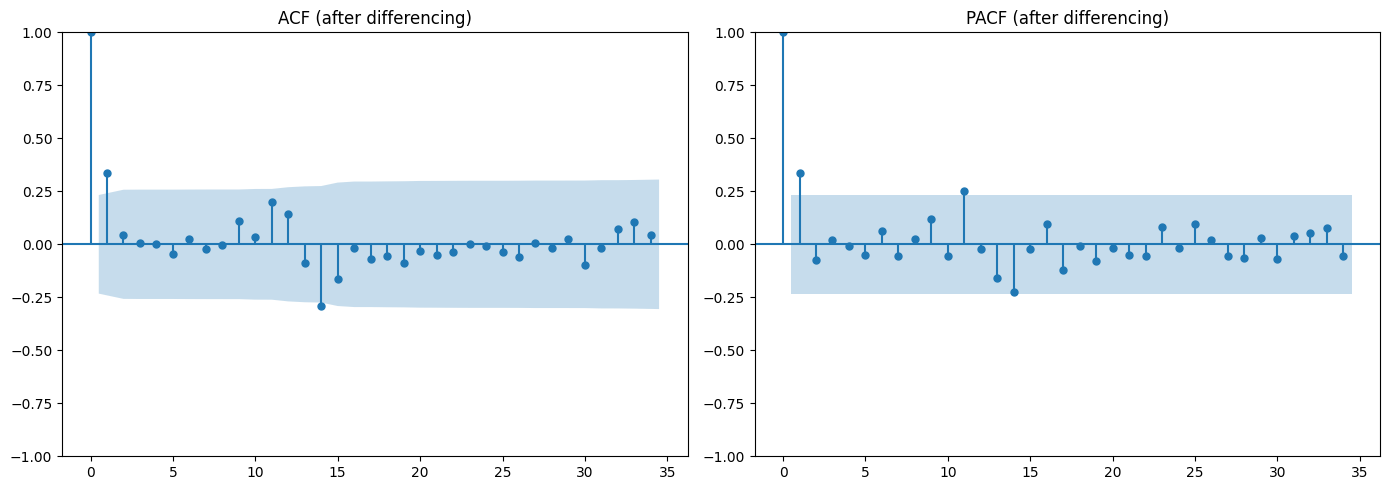

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

n = len(df["detrended"].dropna())

plot_acf(df["detrended"].dropna(), ax=axes[0], lags=n//2 - 1)
axes[0].set_title("ACF (after differencing)")

plot_pacf(df["detrended"].dropna(), ax=axes[1], lags=n//2 - 1, method="ywm")
axes[1].set_title("PACF (after differencing)")

plt.tight_layout()
plt.show()

The model with the lowest AIC is usually the best choice.

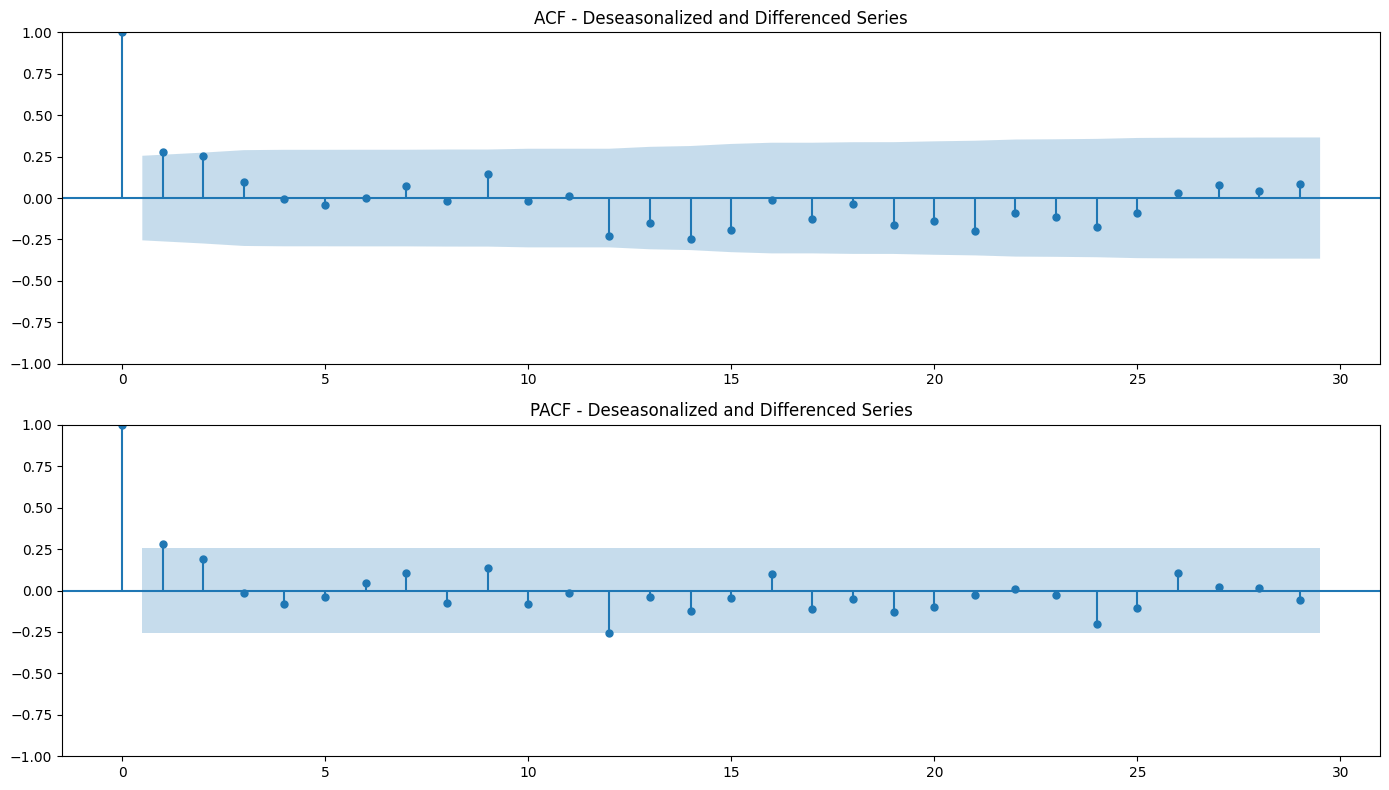

In [22]:
stl = STL(df['basket_price'], period=12)
res = stl.fit()

df['deseasonalized'] = df["basket_price"].diff(12)

df['deseasonalized_diff'] = df['deseasonalized'].diff()

diff_series = df['deseasonalized_diff'].dropna()

max_lags = min(40, len(diff_series) // 2)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
plot_acf(diff_series, ax=axes[0], lags=max_lags)
axes[0].set_title('ACF - Deseasonalized and Differenced Series')
plot_pacf(diff_series, ax=axes[1], lags=max_lags, method='ywm')
axes[1].set_title('PACF - Deseasonalized and Differenced Series')
plt.tight_layout()
plt.show()


In [23]:
df = df.set_index("Місяць")
model_a = ARIMA(df["basket_price"], order=(1, 1, 1)).fit()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [24]:
print("ARIMA(1,1,1):", model_a.summary())

ARIMA(1,1,1):                                SARIMAX Results                                
Dep. Variable:           basket_price   No. Observations:                   72
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -360.331
Date:                Mon, 28 Apr 2025   AIC                            726.662
Time:                        13:54:12   BIC                            733.450
Sample:                    01-01-2019   HQIC                           729.361
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6534      0.223      2.930      0.003       0.216       1.090
ma.L1         -0.2232      0.295     -0.757      0.449      -0.801       0.354
sigma2      1492.7377    175.935      

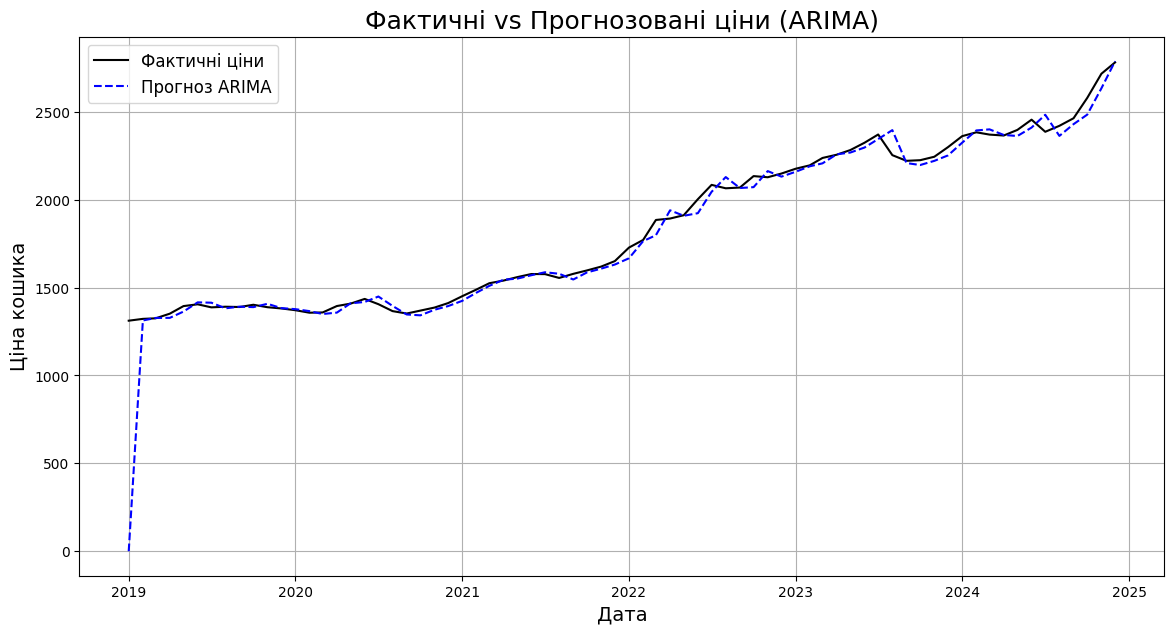

In [25]:
pred = model_a.predict(start=df.index[0], end=df.index[-1], typ="levels")

plt.figure(figsize=(14, 7))
plt.plot(df.index, df["basket_price"], label="Фактичні ціни", color='black')
plt.plot(df.index, pred, label="Прогноз ARIMA", color='blue', linestyle="--")
plt.title("Фактичні vs Прогнозовані ціни (ARIMA)", fontsize=18)
plt.xlabel("Дата", fontsize=14)
plt.ylabel("Ціна кошика", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


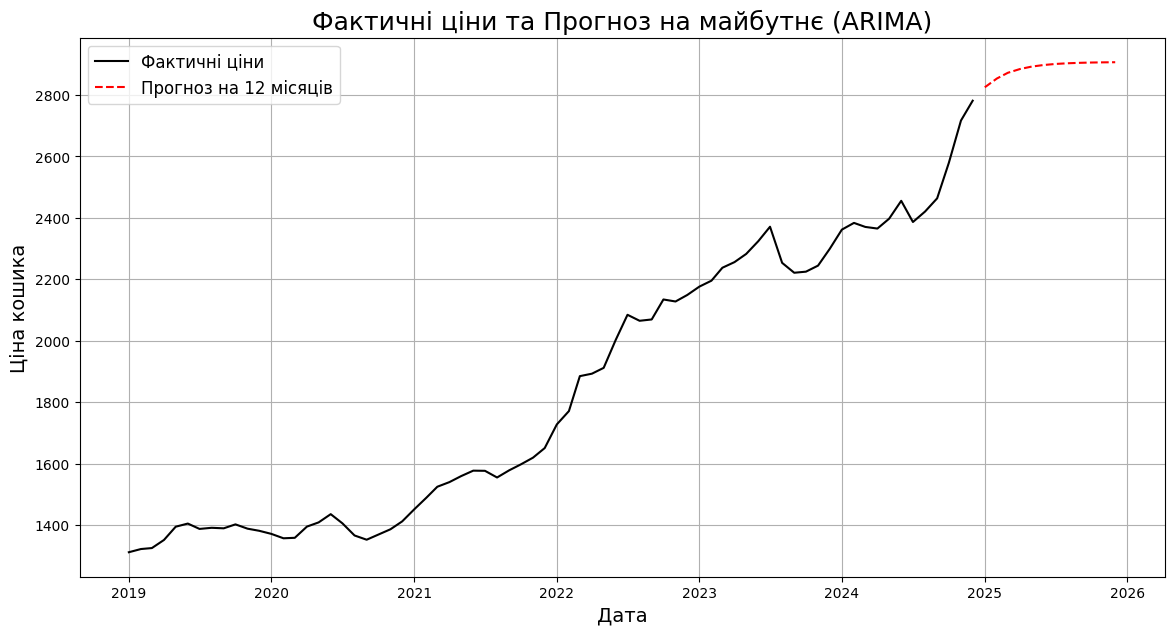

In [28]:
model_a = ARIMA(df["basket_price"], order=(1, 1, 1)).fit()

steps_ahead = 12

forecast = model_a.forecast(steps=steps_ahead)

last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=steps_ahead, freq='MS')

forecast = pd.Series(forecast, index=forecast_index)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df["basket_price"], label="Фактичні ціни", color='black')
plt.plot(forecast.index, forecast, label="Прогноз на 12 місяців", color='red', linestyle="--")
plt.title("Фактичні ціни та Прогноз на майбутнє (ARIMA)", fontsize=18)
plt.xlabel("Дата", fontsize=14)
plt.ylabel("Ціна кошика", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()